In [1]:
%pip install -qU langchain-together

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Add this at the beginning of your notebook
%load_ext autoreload
%autoreload 2

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from agent_hub.orchestrator.orchestrator import Orchestrator, OrchestratorInput
from agent_hub.browser.browser_agent import BrowserUse
from agent_hub.cli.cli_agent import CLIAgent
from agent_hub.graph import State
from agent_hub.front_llm import FrontLLM
browse_use = BrowserUse()
cli_agent = CLIAgent()
agents = [browse_use, cli_agent]
orchestrator = Orchestrator(available_agents=agents)
front_llm = FrontLLM()
await orchestrator.setup()

def next_step(state: State):
    next_agent_name = state["next_agent_name"]
    if next_agent_name is not None:
        return next_agent_name
    else:
        return front_llm.name

def is_computer_interaction_required(state: State):
    is_computer_interaction_required = state["is_computer_interaction_required"]
    if is_computer_interaction_required:
        return orchestrator.name
    else:
        return END

graph_builder = StateGraph(State)

graph_builder.add_node(orchestrator.name, orchestrator)
graph_builder.add_node(front_llm.name, front_llm)
graph_builder.add_edge(START, front_llm.name)
graph_builder.add_conditional_edges(front_llm.name, is_computer_interaction_required)
for agent in agents:
    graph_builder.add_node(agent.name, agent)
    graph_builder.add_edge(agent.name, orchestrator.name)

graph_builder.add_conditional_edges(orchestrator.name, next_step)


graph = graph_builder.compile()

Setting up the orchestrator
Setting up agent: BrowserUse
BrowseUse is setting up
Setting up agent: CLIAgent
CLIAgent is setting up
Orchestrator setup complete


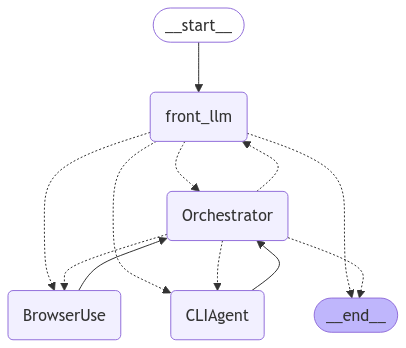

In [3]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [13]:
from langchain_core.messages import HumanMessage
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [HumanMessage(content=user_input)], "user_input": user_input}):
        for value in event.values():
            print(value)
            print("Assistant:", value["messages"][-1].content)

def invoke_graph(user_input: str):
    return graph.invoke({"messages": [HumanMessage(content=user_input)], "user_input": user_input})



In [22]:
invoke_graph("What is the time now in Paris?")

Inside Orchestrator, current plan: None
************************************************************
Executing task: Search flights
by calling agent: BrowserUse
with input: {'query': 'search flights from Morocco to Paris'}
************************************************************
Sync BrowseUse is calling the available agents for the task: query='search flights from Morocco to Paris'
BrowseUse has finished the task: query='search flights from Morocco to Paris'
Inside Orchestrator, current plan: {
    "tasks": [
        {
            "name": "Search flights",
            "description": "Find available flights from Morocco to Paris",
            "execution_agent_name": "BrowserUse",
            "task_status": "pending"
        },
        {
            "name": "Select flight",
            "description": "Choose the best flight option based on price and schedule",
            "execution_agent_name": "BrowserUse",
            "task_status": "pending"
        },
        {
            "nam

{'plan': OrchestratorPlan(tasks=[Task(name='Search flights', description='Find available flights from Morocco to Paris', execution_agent_name='BrowserUse', task_status=<TaskStatus.PENDING: 'pending'>), Task(name='Select flight', description='Choose the best flight option based on price and schedule', execution_agent_name='BrowserUse', task_status=<TaskStatus.PENDING: 'pending'>), Task(name='Book flight', description='Enter passenger information and complete the booking process', execution_agent_name='CLIAgent', task_status=<TaskStatus.PENDING: 'pending'>)], goal='Book a flight to Paris from Morocco', current_task_index=2, is_completed=True),
 'last_task_status': <TaskStatus.SUCCESS: 'success'>,
 'last_task_output': 'CLIAgent has finished the task: Enter passenger information and complete the booking process',
 'next_agent_input': None,
 'next_agent_name': None,
 'messages': [HumanMessage(content='Can you book a flight to Paris from Morocco?', additional_kwargs={}, response_metadata={},

In [4]:
from agent_hub.browser.browser_agent import BrowserUse
browse_use = BrowserUse()
await browse_use.setup()

# Now you can use it in your graph or directly
result = await browse_use.__acall__({
    "next_agent_input": {
        "query": "Find a one-way flight from Bali to Oman on 12 January 2025 on Google Flights"
    }
})

BrowserUse is ready
Async BrowserUse is calling the available agents for the task: query='Find a one-way flight from Bali to Oman on 12 January 2025 on Google Flights'
INFO     [agent] 🚀 Starting task: Find a one-way flight from Bali to Oman on 12 January 2025 on Google Flights
INFO     [agent] 
📍 Step 1
WARNING  [browser] Page load failed, continuing...
ERROR    [agent] ❌ Result failed 1/5 times:
 Unexpected error: 
Stacktrace:
Traceback (most recent call last):
  File "c:\Users\Soufiane.DAHIMI\Projects\Nexus Agents\.venv\Lib\site-packages\browser_use\agent\service.py", line 118, in step
    state = await self.controller.browser.get_state(use_vision=self.use_vision)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Soufiane.DAHIMI\Projects\Nexus Agents\.venv\Lib\site-packages\browser_use\browser\service.py", line 503, in get_state
    session = await self.get_session()
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Soufiane.DAHIM